Using device: cuda
Loading FNC-1 Datasets...
Dataset size: 49972
Training samples: 39977
Test samples: 9995

INITIALIZING MODELS

Loading DistilBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERT parameters: 66,560,772

Loading TinyBERT...


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

TinyBERT parameters: 14,390,828

Creating datasets...
Creating DataLoaders with optimized settings...
Train batches: 1250
Test batches: 313

################################################################################
PROCESSING: DistilBERT
################################################################################

Training DistilBERT
Total training steps: 3750
Batches per epoch: 1250

[Epoch 1/3]
Training...
  Total batches: 1250
  Processing batch 0/1250 (0.0%)


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

  Processing batch 100/1250 (8.0%)
  Processing batch 200/1250 (16.0%)
  Processing batch 300/1250 (24.0%)
  Processing batch 400/1250 (32.0%)
  Processing batch 500/1250 (40.0%)
  Processing batch 600/1250 (48.0%)
  Processing batch 700/1250 (56.0%)
  Processing batch 800/1250 (64.0%)
  Processing batch 900/1250 (72.0%)
  Processing batch 1000/1250 (80.0%)
  Processing batch 1100/1250 (88.0%)
  Processing batch 1200/1250 (96.0%)
Validating...
  Evaluating on 313 batches...
  Eval batch 0/313
  Eval batch 50/313
  Eval batch 100/313
  Eval batch 150/313
  Eval batch 200/313
  Eval batch 250/313
  Eval batch 300/313

Epoch 1/3 Summary:
  Train Loss: 0.3740, Train Acc: 0.8670
  Val Loss: 0.1708, Val Acc: 0.9409
  Time: 1287.34s (21.46 min)

[Epoch 2/3]
Training...
  Total batches: 1250
  Processing batch 0/1250 (0.0%)
  Processing batch 100/1250 (8.0%)
  Processing batch 200/1250 (16.0%)
  Processing batch 300/1250 (24.0%)
  Processing batch 400/1250 (32.0%)
  Processing batch 500/1250 (

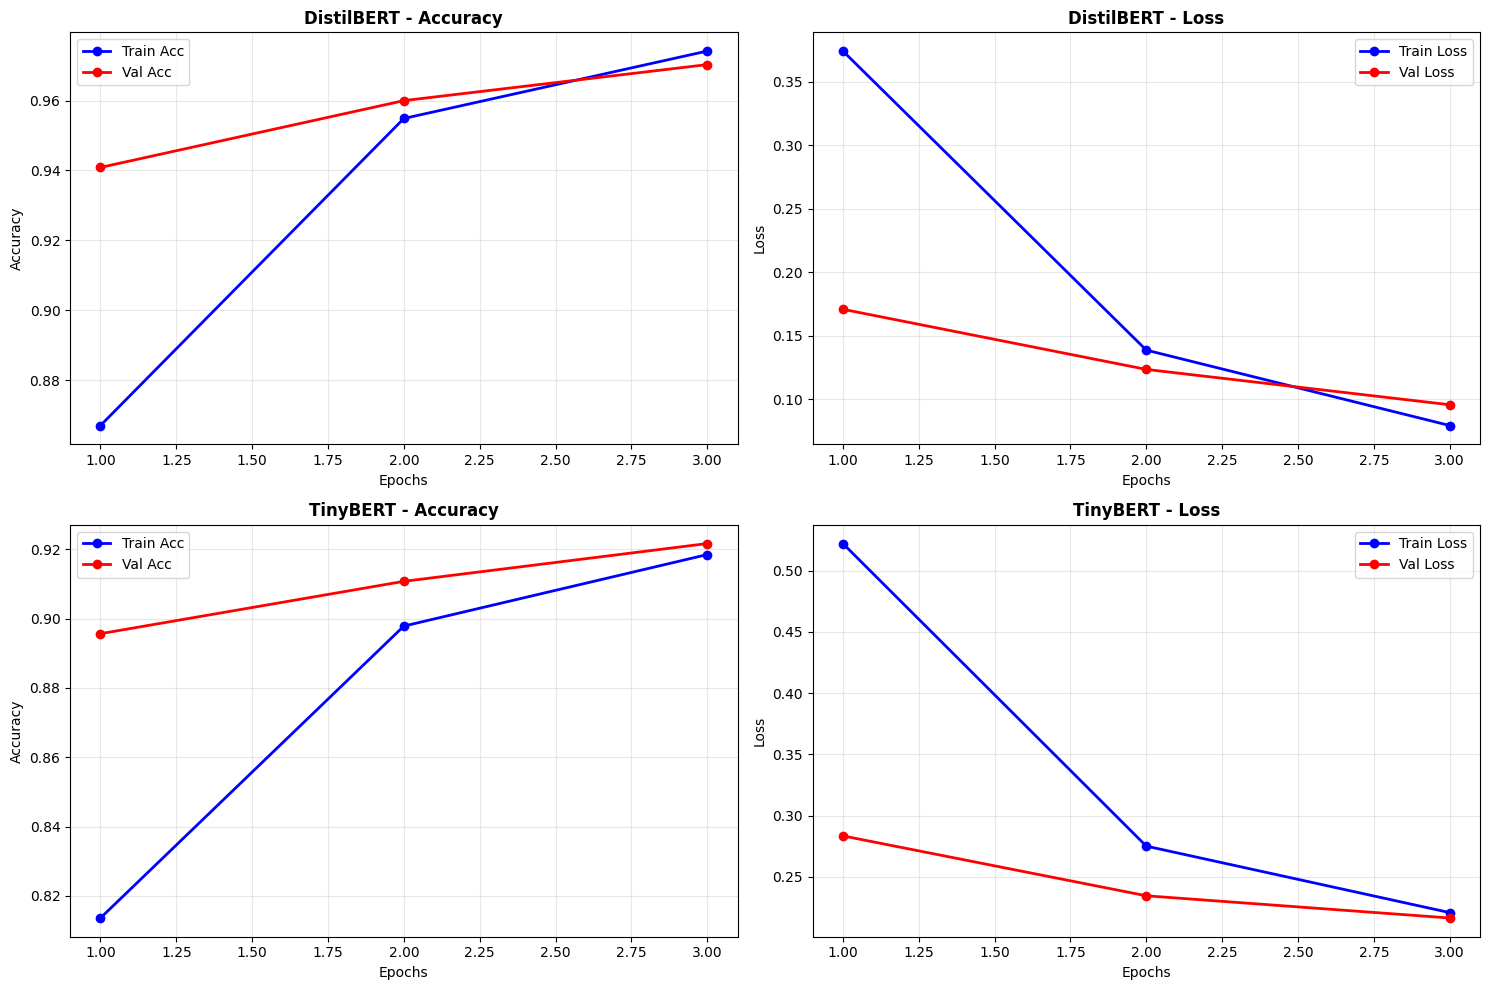

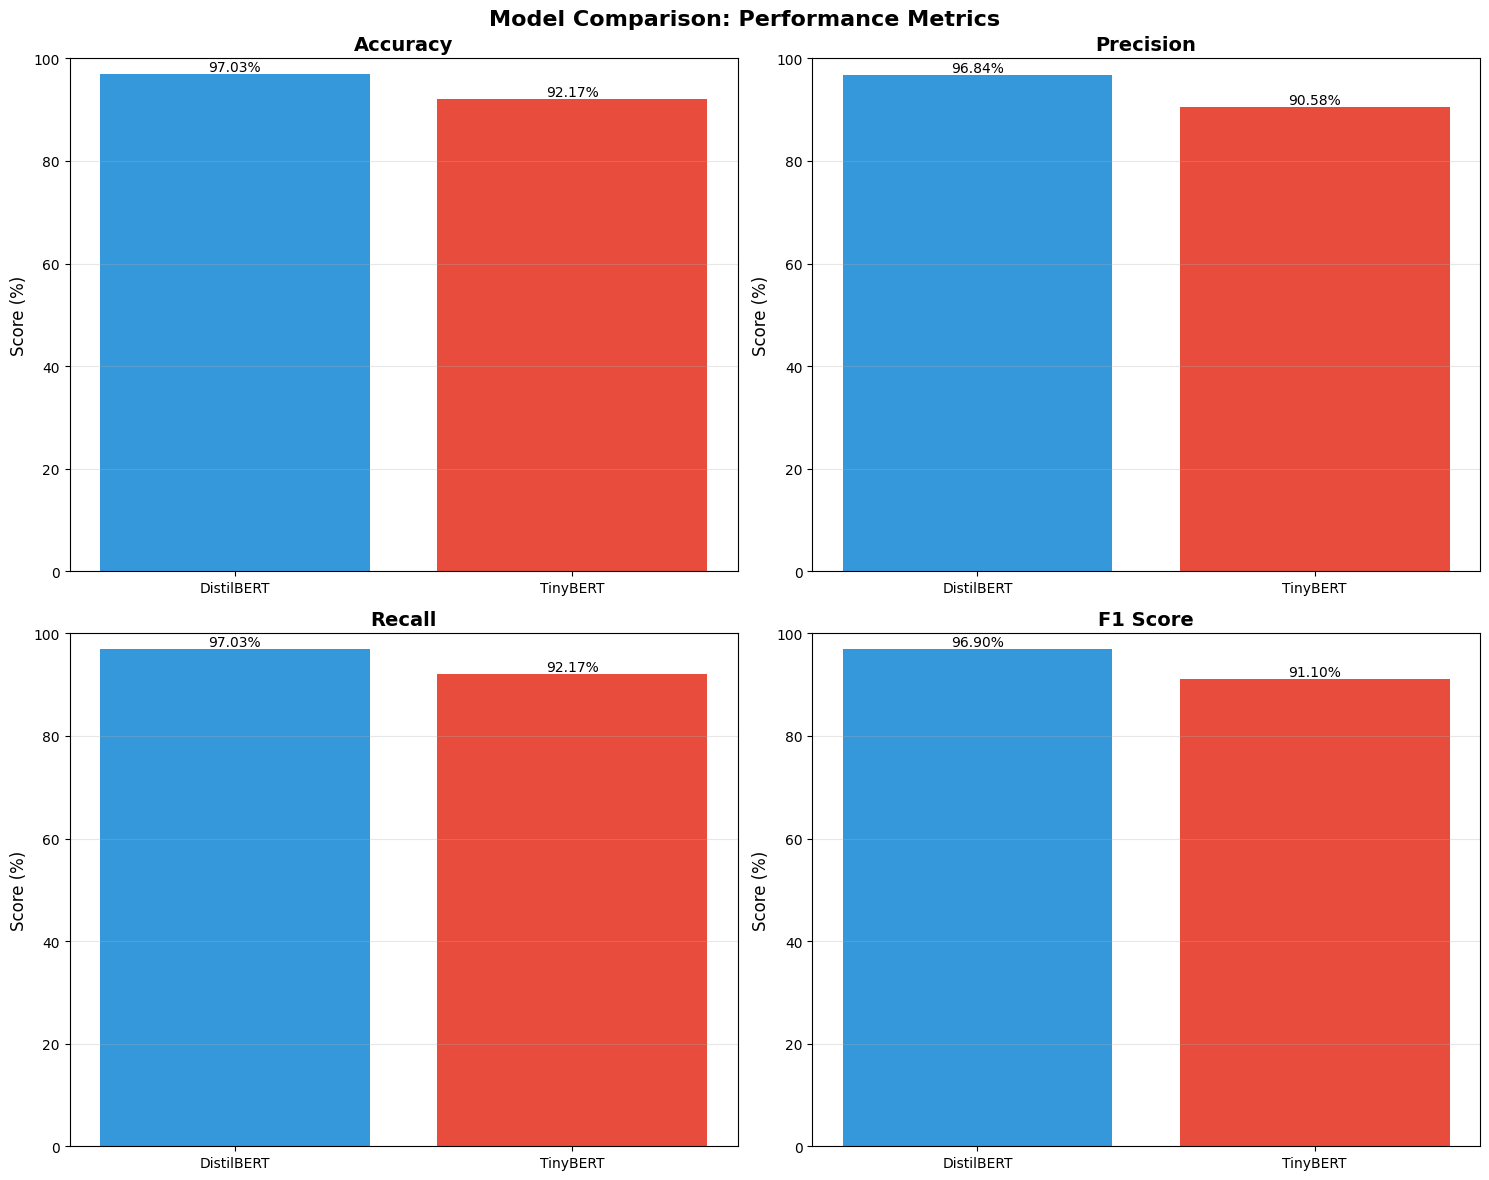

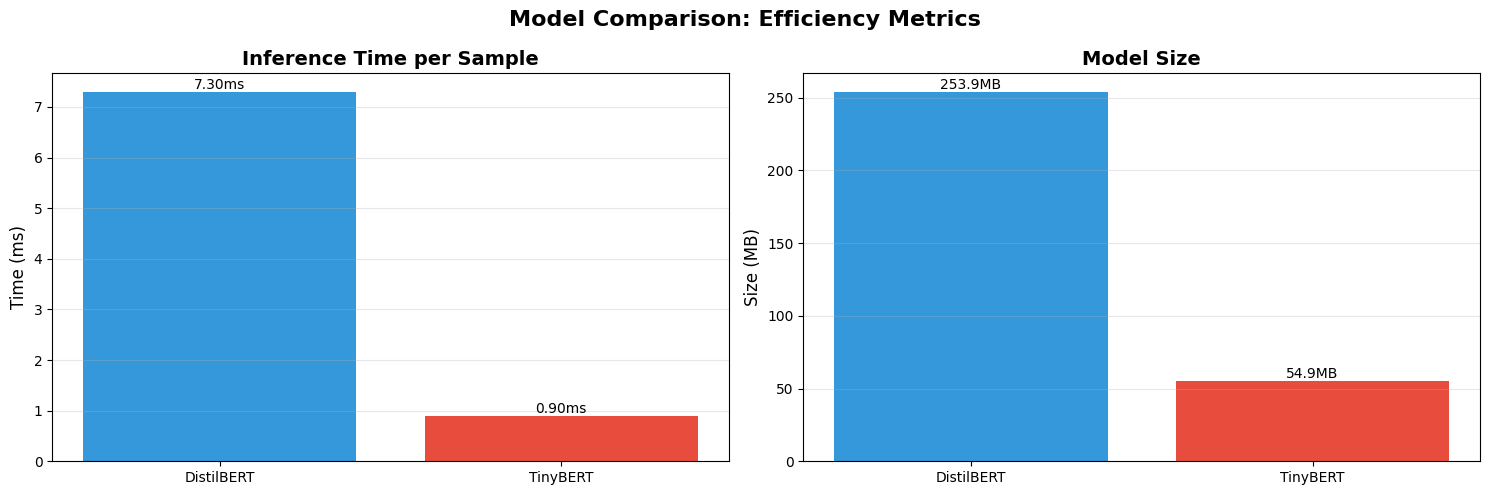

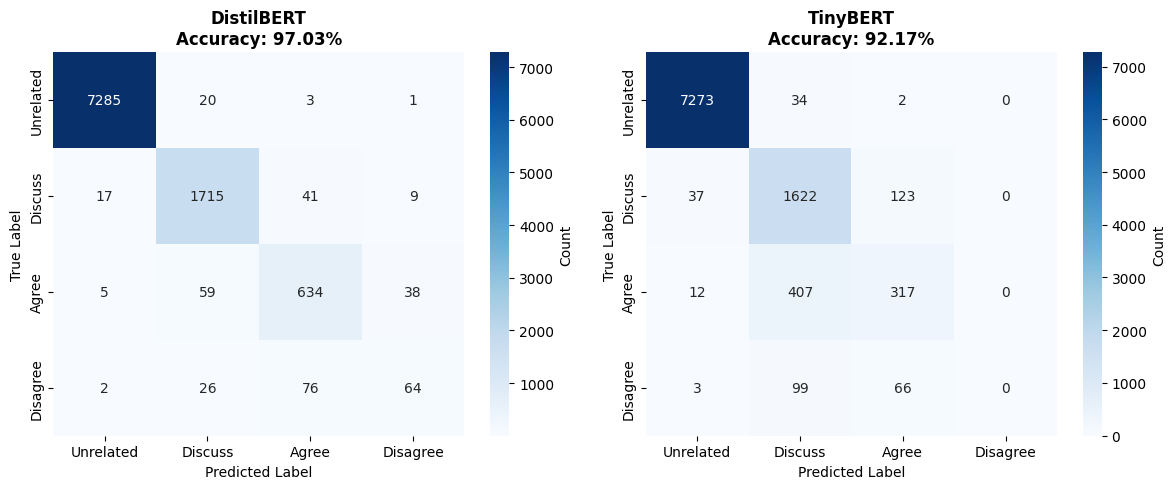


COMPREHENSIVE COMPARISON REPORT

────────────────────────────────────────────────────────────────────────────────
MODEL: DistilBERT
────────────────────────────────────────────────────────────────────────────────

[Overall Metrics]
Metric               | Score          
----------------------------------------
Accuracy             | 97.03%
Precision            | 96.84%
Recall               | 97.03%
F1-Score             | 96.90%

[Efficiency Metrics]
Metric               | Value          
----------------------------------------
Model Size           | 253.91 MB
Inference Time       | 7.2989 ms/sample

[Per-Class Performance]
           precision    recall  f1-score  support
Unrelated   0.996716  0.996716  0.996716   7309.0
Discuss     0.942308  0.962402  0.952249   1782.0
Agree       0.840849  0.861413  0.851007    736.0
Disagree    0.571429  0.380952  0.457143    168.0

────────────────────────────────────────────────────────────────────────────────
MODEL: TinyBERT
───────────────────

In [2]:
# ==============================================================================
# ENHANCED IMPLEMENTATION: DistilBERT & TinyBERT for Fake News Stance Detection
# Comparing with Base CNN Model
# ==============================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import time
from transformers import (
    DistilBertTokenizer, DistilBertModel,
    AutoTokenizer, AutoModel,
    get_linear_schedule_with_warmup
)
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# CONFIGURATION
# ==========================================
BODY_CSV_PATH = '/kaggle/input/fnc-1/train_bodies.csv'
STANCE_CSV_PATH = '/kaggle/input/fnc-1/train_stances.csv'

MAX_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500
VALIDATION_SPLIT = 0.2

# ==========================================
# DATA LOADING
# ==========================================
def load_data():
    print("Loading FNC-1 Datasets...")
    bodies_df = pd.read_csv(BODY_CSV_PATH)
    stances_df = pd.read_csv(STANCE_CSV_PATH)
    data = pd.merge(stances_df, bodies_df, on='Body ID')
    data['text'] = data['Headline'] + " [SEP] " + data['articleBody']
    label_map = {'unrelated': 0, 'discuss': 1, 'agree': 2, 'disagree': 3}
    data['label'] = data['Stance'].map(label_map)
    return data[['text', 'label']]

data = load_data()
print(f"Dataset size: {len(data)}")

X_train, X_test, y_train, y_test = train_test_split(
    data['text'].values, 
    data['label'].values, 
    test_size=VALIDATION_SPLIT, 
    random_state=42,
    stratify=data['label'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

del data
gc.collect()

# ==========================================
# DATASET CLASS
# ==========================================
class StanceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ==========================================
# MODEL ARCHITECTURES
# ==========================================
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class TinyBERTClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super(TinyBERTClassifier, self).__init__()
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(312, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# ==========================================
# TRAINING FUNCTIONS
# ==========================================
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    total_batches = len(data_loader)
    print(f"  Total batches: {total_batches}")
    
    for batch_idx, batch in enumerate(data_loader):
        if batch_idx % 100 == 0:
            print(f"  Processing batch {batch_idx}/{total_batches} ({batch_idx/total_batches*100:.1f}%)")
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader), correct / total

def eval_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    print(f"  Evaluating on {len(data_loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch_idx % 50 == 0:
                print(f"  Eval batch {batch_idx}/{len(data_loader)}")
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(data_loader), correct / total, all_preds, all_labels

def train_model(model, train_loader, val_loader, epochs, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    print(f"Total training steps: {total_steps}")
    print(f"Batches per epoch: {len(train_loader)}")
    
    for epoch in range(epochs):
        print(f"\n[Epoch {epoch+1}/{epochs}]")
        start_time = time.time()
        
        print("Training...")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device
        )
        
        print("Validating...")
        val_loss, val_acc, _, _ = eval_model(
            model, val_loader, criterion, device
        )
        
        epoch_time = time.time() - start_time
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nEpoch {epoch+1}/{epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Time: {epoch_time:.2f}s ({epoch_time/60:.2f} min)")
    
    return history

# ==========================================
# EVALUATION & COMPARISON
# ==========================================
def measure_inference_time(model, data_loader, device, num_samples=1000):
    model.eval()
    total_time = 0.0
    count = 0
    
    print(f"  Measuring inference time on {num_samples} samples...")
    
    with torch.no_grad():
        for batch in data_loader:
            if count >= num_samples:
                break
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            start_time = time.time()
            _ = model(input_ids, attention_mask)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.time() - start_time
            
            total_time += elapsed
            count += input_ids.size(0)
    
    avg_time_ms = (total_time / count) * 1000
    print(f"  Average inference time: {avg_time_ms:.4f} ms/sample")
    return avg_time_ms

def get_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024 ** 2)
    return size_mb

def plot_comparison(results_dict):
    models = list(results_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Comparison: Performance Metrics', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        values = [results_dict[m][metric] * 100 for m in models]
        bars = ax.bar(models, values, color=['#3498db', '#e74c3c', '#2ecc71'])
        ax.set_ylabel('Score (%)', fontsize=12)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=14, fontweight='bold')
        ax.set_ylim([0, 100])
        ax.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_efficiency_comparison(results_dict):
    models = list(results_dict.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Model Comparison: Efficiency Metrics', fontsize=16, fontweight='bold')
    
    inference_times = [results_dict[m]['inference_time_ms'] for m in models]
    model_sizes = [results_dict[m]['model_size_mb'] for m in models]
    
    ax1 = axes[0]
    bars1 = ax1.bar(models, inference_times, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax1.set_ylabel('Time (ms)', fontsize=12)
    ax1.set_title('Inference Time per Sample', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms', ha='center', va='bottom', fontsize=10)
    
    ax2 = axes[1]
    bars2 = ax2.bar(models, model_sizes, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax2.set_ylabel('Size (MB)', fontsize=12)
    ax2.set_title('Model Size', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}MB', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results_dict, target_names):
    num_models = len(results_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 5))
    
    if num_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(results_dict.items()):
        cm = results['confusion_matrix']
        ax = axes[idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=target_names, yticklabels=target_names,
                   ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title(f'{model_name}\nAccuracy: {results["accuracy"]*100:.2f}%',
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_training_history(results_dict):
    num_models = len(results_dict)
    fig, axes = plt.subplots(num_models, 2, figsize=(15, 5*num_models))
    
    if num_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, results) in enumerate(results_dict.items()):
        history = results['history']
        epochs_range = range(1, len(history['train_acc']) + 1)
        
        ax1 = axes[idx, 0]
        ax1.plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
        ax1.plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
        ax1.set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[idx, 1]
        ax2.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
        ax2.plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
        ax2.set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_detailed_report(results_dict, target_names):
    print("\n" + "="*80)
    print("COMPREHENSIVE COMPARISON REPORT")
    print("="*80)
    
    for model_name, results in results_dict.items():
        print(f"\n{'─'*80}")
        print(f"MODEL: {model_name}")
        print(f"{'─'*80}")
        
        print(f"\n[Overall Metrics]")
        print(f"{'Metric':<20} | {'Score':<15}")
        print("-" * 40)
        print(f"{'Accuracy':<20} | {results['accuracy']*100:.2f}%")
        print(f"{'Precision':<20} | {results['precision']*100:.2f}%")
        print(f"{'Recall':<20} | {results['recall']*100:.2f}%")
        print(f"{'F1-Score':<20} | {results['f1_score']*100:.2f}%")
        
        print(f"\n[Efficiency Metrics]")
        print(f"{'Metric':<20} | {'Value':<15}")
        print("-" * 40)
        print(f"{'Model Size':<20} | {results['model_size_mb']:.2f} MB")
        print(f"{'Inference Time':<20} | {results['inference_time_ms']:.4f} ms/sample")
        
        print(f"\n[Per-Class Performance]")
        report_df = pd.DataFrame(results['classification_report']).transpose()
        print(report_df[['precision', 'recall', 'f1-score', 'support']].iloc[:-3])
    
    print("\n" + "="*80)
    print("COMPARATIVE SUMMARY")
    print("="*80)
    
    summary_data = []
    for model_name, results in results_dict.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy (%)': f"{results['accuracy']*100:.2f}",
            'F1-Score (%)': f"{results['f1_score']*100:.2f}",
            'Inference (ms)': f"{results['inference_time_ms']:.4f}",
            'Size (MB)': f"{results['model_size_mb']:.2f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

# ==========================================
# MAIN EXECUTION
# ==========================================
print("\n" + "="*60)
print("INITIALIZING MODELS")
print("="*60)

print("\nLoading DistilBERT...")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBERTClassifier().to(device)
print(f"DistilBERT parameters: {sum(p.numel() for p in distilbert_model.parameters()):,}")

print("\nLoading TinyBERT...")
tinybert_tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
tinybert_model = TinyBERTClassifier().to(device)
print(f"TinyBERT parameters: {sum(p.numel() for p in tinybert_model.parameters()):,}")

print("\nCreating datasets...")
distilbert_train_dataset = StanceDataset(X_train, y_train, distilbert_tokenizer, MAX_LENGTH)
distilbert_test_dataset = StanceDataset(X_test, y_test, distilbert_tokenizer, MAX_LENGTH)

tinybert_train_dataset = StanceDataset(X_train, y_train, tinybert_tokenizer, MAX_LENGTH)
tinybert_test_dataset = StanceDataset(X_test, y_test, tinybert_tokenizer, MAX_LENGTH)

print("Creating DataLoaders with optimized settings...")
distilbert_train_loader = DataLoader(
    distilbert_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
distilbert_test_loader = DataLoader(
    distilbert_test_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

tinybert_train_loader = DataLoader(
    tinybert_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
tinybert_test_loader = DataLoader(
    tinybert_test_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(distilbert_train_loader)}")
print(f"Test batches: {len(distilbert_test_loader)}")

models_config = {
    'DistilBERT': {
        'model': distilbert_model,
        'train_loader': distilbert_train_loader,
        'test_loader': distilbert_test_loader
    },
    'TinyBERT': {
        'model': tinybert_model,
        'train_loader': tinybert_train_loader,
        'test_loader': tinybert_test_loader
    }
}

results = {}
target_names = ['Unrelated', 'Discuss', 'Agree', 'Disagree']

for model_name, config in models_config.items():
    print(f"\n{'#'*80}")
    print(f"PROCESSING: {model_name}")
    print(f"{'#'*80}")
    
    model = config['model']
    train_loader = config['train_loader']
    test_loader = config['test_loader']
    
    training_start = time.time()
    history = train_model(model, train_loader, test_loader, EPOCHS, model_name)
    training_time = time.time() - training_start
    
    print(f"\n{model_name} training completed in {training_time:.2f}s ({training_time/60:.2f} min)")
    
    print(f"\nRunning final evaluation for {model_name}...")
    criterion = nn.CrossEntropyLoss()
    _, val_acc, y_pred, y_true = eval_model(model, test_loader, criterion, device)
    
    print("Calculating metrics...")
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    print("Measuring inference time...")
    inference_time = measure_inference_time(model, test_loader, device)
    
    print("Calculating model size...")
    model_size = get_model_size(model)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'inference_time_ms': inference_time,
        'model_size_mb': model_size,
        'history': history,
        'training_time_min': training_time / 60
    }
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  F1-Score: {f1*100:.2f}%")
    print(f"  Model Size: {model_size:.2f} MB")
    print(f"  Inference Time: {inference_time:.4f} ms/sample")
    
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

plot_training_history(results)
plot_comparison(results)
plot_efficiency_comparison(results)
plot_confusion_matrices(results, target_names)
generate_detailed_report(results, target_names)

print("\n" + "="*60)
print("EXECUTION COMPLETE")
print("="*60)